# Load Dependencies

In [2]:
! export GLBACKEND="pytorch"
import numpy as np
import pandas as pd
from pandas import DataFrame
import glob
import torch 
from torch.utils.data import Dataset
import torch.optim as optim
from script_baseline.SEMG import Get_SEMG
from script_baseline.GCN import GCN1
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# Load Data

In [5]:
data_file = '../data1/data1.csv'
mol_dir = '../data1/data1_sdf_files/'

In [6]:
tmp_df = pd.read_csv(data_file)
lig_smiles = tmp_df['Ligand'].to_list()
add_smiles = tmp_df['Additive'].to_list()
base_smiles = tmp_df['Base'].to_list()
ar_ha_smiles = tmp_df['Aryl halide'].to_list()
labels_ori = tmp_df['Output'].to_list()

lig_smi_set = list(set(lig_smiles))
add_smi_set = list(set(add_smiles))
base_smi_set = list(set(base_smiles))
ar_ha_smi_set = list(set(ar_ha_smiles))
labels_ori=np.array(labels_ori)
label_std = (np.array(labels_ori)-np.min(labels_ori))/(np.max(labels_ori)-np.min(labels_ori))

In [7]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
lig_files = sorted(glob.glob(mol_dir+'lig_*.sdf'),key=sort_func)
add_files = sorted(glob.glob(mol_dir+'add_*.sdf'),key=sort_func)
base_files = sorted(glob.glob(mol_dir+'base_*.sdf'),key=sort_func)
ar_ha_files = sorted(glob.glob(mol_dir+'ar_ha_*.sdf'),key=sort_func)

In [8]:
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

# Generate Baseline MG

In [10]:
lig_file_graph_dict=Get_SEMG(lig_files)

lig_0
lig_1
lig_2
lig_3


In [11]:
add_file_graph_dict=Get_SEMG(add_files)

add_0
add_1
add_2
add_3
add_4
add_5
add_6
add_7
add_8
add_9
add_10
add_11
add_12
add_13
add_14
add_15
add_16
add_17
add_18
add_19
add_20
add_21


In [12]:
base_file_graph_dict=Get_SEMG(base_files)

base_0
base_1
base_2


In [13]:
ar_ha_file_graph_dict=Get_SEMG(ar_ha_files)

ar_ha_0
ar_ha_1
ar_ha_2
ar_ha_3
ar_ha_4
ar_ha_5
ar_ha_6
ar_ha_7
ar_ha_8
ar_ha_9
ar_ha_10
ar_ha_11
ar_ha_12
ar_ha_13
ar_ha_14


# Load Graph Dataset

In [14]:
class Graph_DataSet1(Dataset):

    def __init__(self, root,csv_dir,sdf_dir, train=True, transform = None, target_transform=None):
        super(Graph_DataSet1, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.smiles_name_dict=smiles_name_dict
        self.lig_file_graph_dict=lig_file_graph_dict
        self.add_file_graph_dict=add_file_graph_dict
        self.base_file_graph_dict=base_file_graph_dict
        self.ar_ha_file_graph_dict=ar_ha_file_graph_dict
        if self.train :
            file_annotation = root + csv_dir
            sdf_folder = root + sdf_dir
        else:
            file_annotation = root + csv_dir
            sdf_folder = root + sdf_dir
        df = pd.read_csv(file_annotation)
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        lig_smi = df['Ligand'].to_list()
        add_smi = df['Additive'].to_list()
        base_smi = df['Base'].to_list()
        ar_ha_smi = df['Aryl halide'].to_list()
        
        lig_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in lig_smi]
        add_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in add_smi]
        base_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in base_smi]
        ar_ha_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in ar_ha_smi]
        
        self.lig_file_names = lig_file_names
        self.add_file_names = add_file_names
        self.base_file_names = base_file_names
        self.ar_ha_file_names = ar_ha_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        lig_name = self.lig_file_names[index]
        add_name = self.add_file_names[index]
        base_name = self.base_file_names[index]
        ar_ha_name = self.ar_ha_file_names[index]
        label = self.target_std[index]

        graph_1 = lig_file_graph_dict[lig_name]
        graph_2 = add_file_graph_dict[add_name]
        graph_3 = base_file_graph_dict[base_name]
        graph_4 = ar_ha_file_graph_dict[ar_ha_name]
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat'],graph_4,graph_4.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)


# Tain Model

In [15]:
loss = 'mse'
batch_size = 128
shuffle = np.array(list(range(3955)))
np.random.shuffle(shuffle)
train_index = shuffle[:2769]
val_index = shuffle[2769:]
dataset = Graph_DataSet1(root='../Data/data1',csv_dir='/data1.csv',sdf_dir='/xtb_sdf/')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data)     

In [16]:
model_opt = GCN1(543,256,1,multi_graph_opt='mean',output_opt='max',layer=3)
optimizer = optim.Adam(model_opt.parameters())
loss_func = torch.nn.L1Loss()

for epoch in range(50):
    get_output=[]
    all_loss = []
    model_opt.train()
    for i, data in enumerate(train_data):
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        get_output.append(outputs)
        labels = torch.tensor(labels)        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print(epoch,'Train MAE',np.mean(all_loss))
    model_opt.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model_opt(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    print(epoch,'Test MAE',np.mean(all_loss))   

0 Train MAE 0.21929454519791058
0 Test MAE 0.20262963339789325
1 Train MAE 0.19110307412317773
1 Test MAE 0.18253183300159767
2 Train MAE 0.17112744860532497
2 Test MAE 0.18660705725862298
3 Train MAE 0.1613498695402239
3 Test MAE 0.18061680574349956
4 Train MAE 0.1547522673989598
4 Test MAE 0.17395493580525812
5 Train MAE 0.14984261488218548
5 Test MAE 0.16937234227431747
6 Train MAE 0.14770384138426607
6 Test MAE 0.15585090049540581
7 Train MAE 0.14786655155398823
7 Test MAE 0.14908619568754392
8 Train MAE 0.14546389813676006
8 Test MAE 0.1534498872242547
9 Train MAE 0.14521184411096486
9 Test MAE 0.14833708778783058
10 Train MAE 0.1438107479767024
10 Test MAE 0.14338701294198927
11 Train MAE 0.14462266615189054
11 Test MAE 0.15452651365690043
12 Train MAE 0.1431820753453069
12 Test MAE 0.15213758802895808
13 Train MAE 0.14246917092632144
13 Test MAE 0.14520531391567296
14 Train MAE 0.1416444741309054
14 Test MAE 0.1433774871798941
15 Train MAE 0.14237652849500065
15 Test MAE 0.14427

In [17]:
test_all_labels_=[]
for i in test_all_labels:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in test_get_output:
    test_get_output_.append(i.tolist())
    
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()

# Results

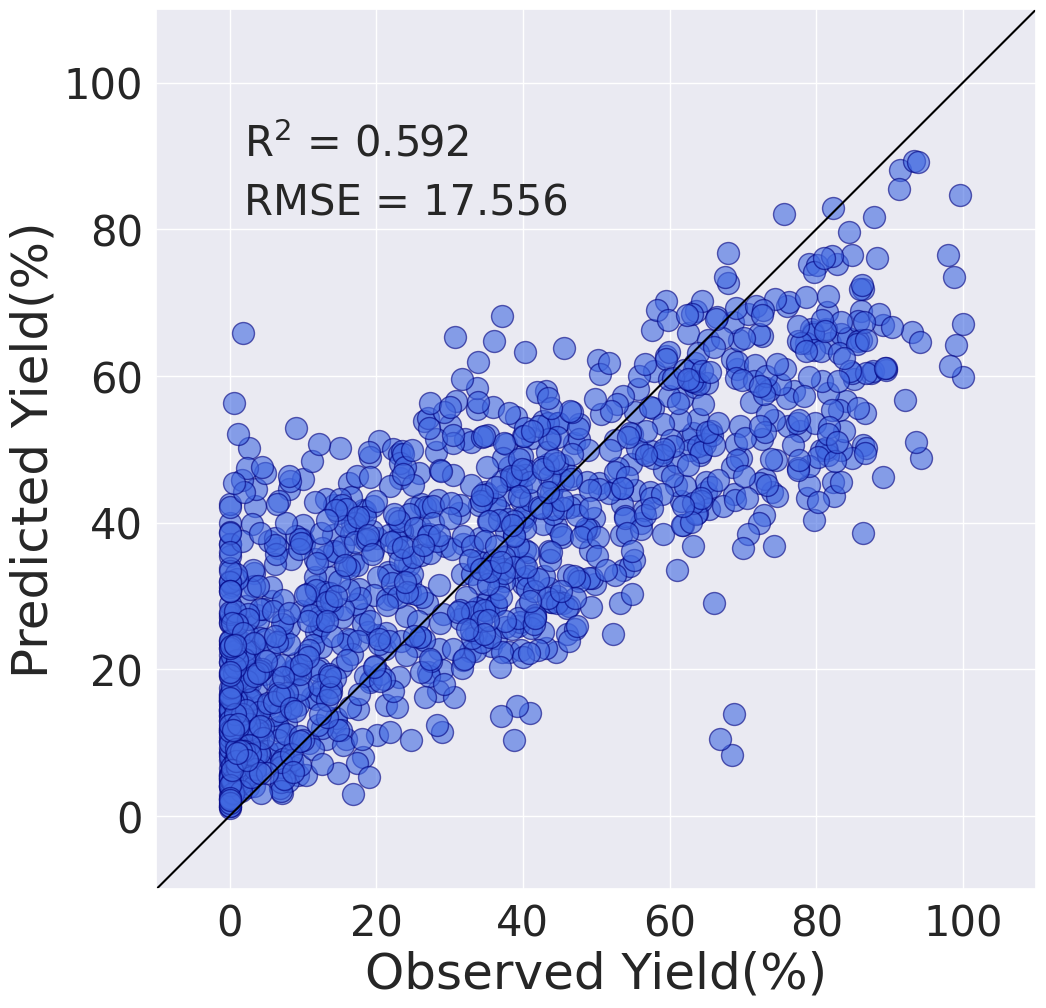

In [18]:
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)
plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [19]:
np.save('../result/data1_SEMG_GCN_y_val.npy',y_val)
np.save('../result/data1_SEMG_GCN_y_pred.npy',y_pred)